# Space Comparison 

We compare the space usage between the $4, 6, 8$ bit versions of the Apache DataSketches (ASF) HyperLogLog implementation alongside the `datasketch` HyperLogLogPlusPlus implementation.  We show that the `datasketch` version has approximately the same size as the ASF $8$ bit implementation when the latter is in full estimation mode.  However, smaller sketches can be made without compromising on the accuracy if $6$ or $4$ bits per bucket are used which use $75\%$ and $50\%$ of the space consumed by either of the $8$ bit variants.

In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
from utils import distinct_number_sequence
import datasketches as ds
import datasketch as d
import mmh3
import matplotlib.pyplot as plt
from timeit import default_timer
%matplotlib inline

In [2]:
class SpaceProfile:
    """Generates an experiment evaluating the update time for different cardinality inputs"""
    def __init__(self, sketch_lgk:int, lg_trials:int, max_lgN:int):
        self.sketch_lgk = sketch_lgk
        self.num_trials = 2**lg_trials
        self.max_lgN = max_lgN
        self.max_num_distincts = np.uint64(2 ** self.max_lgN)
        self.directory_name = "hll_space_profile_"
        if not os.path.exists(self.directory_name):
            os.mkdir(self.directory_name)
        self.file_extension = "_" + datetime.today().strftime('%H%M') + f"lgK_{self.sketch_lgk}_lgT_{lg_trials}"

        # Need to remove repeated items for the program logic in self.run()
        self.plot_points = self._generate_plot_points()
        self.plot_points.extend(self._generate_plot_points())
        self.plot_points = list(set(self.plot_points))
        self.plot_points.sort()
        print(f"Testing {len(self.plot_points)} points with {self.num_trials} trials for average update times:")
        print(self.plot_points)

        # Initialise the data structures for results; one for each method tested 8, 6, datasketch
        # np.ndarrays
        self.DataSketches_results_arr = np.zeros((len(self.plot_points), self.num_trials), dtype=float)
        self.DataSketches_results_arr_6 =  np.zeros_like(self.DataSketches_results_arr)
        self.DataSketches_results_arr_4 =  np.zeros_like(self.DataSketches_results_arr)
        self.datasketch_results_arr = np.zeros_like(self.DataSketches_results_arr)

        # pd.DataFrames
        self.DataSketches_results_df = pd.DataFrame(index=self.plot_points, columns=None)
        self.DataSketches_results_df_6 = pd.DataFrame(index=self.plot_points, columns=None)
        self.DataSketches_results_df_4 = pd.DataFrame(index=self.plot_points, columns=None)
        self.datasketch_results_df = pd.DataFrame(index=self.plot_points, columns=None)
        
    def _generate_plot_points(self) -> list:
        """
        Generates the standard sequence defining the input cardinalites for the experiment
        This is just two points at each power of 2
        """
        all_plot_points = []
        for lgk in range(1, self.max_lgN+1):
            points = np.unique(np.logspace(start=lgk, stop=lgk+1, num=4, endpoint=False, base=2, dtype=np.uint64))
            all_plot_points.extend(points)
        all_plot_points.sort()
        return all_plot_points

    def _is_power_of_two(self, a:np.uint64) -> bool:
        """Bitwise operations to check value a is a power of two"""
        return (a & (a-1) == 0) and a != 0

    def run(self) -> None:
        """Runs the experiment and writes the files every power of two trials."""
        seq_start = np.uint64(2345234)
        distinct_number = np.uint64(3462)
        previous_log_trial_index = 0
        ds_all_results = np.zeros((self.num_trials, len(self.plot_points)))
        ds_all_results_6 = np.zeros_like(ds_all_results)
        ds_all_results_4 = np.zeros_like(ds_all_results)
        d_all_results = np.zeros_like(ds_all_results)

        for trial in range(1, self.num_trials+1):

            # Initialise the sketches
            hll = ds.hll_sketch(self.sketch_lgk, ds.HLL_8)
            hll6 = ds.hll_sketch(self.sketch_lgk, ds.HLL_6)
            hll4 = ds.hll_sketch(self.sketch_lgk, ds.HLL_4)
            h = d.HyperLogLogPlusPlus(p=self.sketch_lgk, hashfunc=lambda x: mmh3.hash64(x, signed=False)[0])
            plot_point_index = 0  # Return to the start of the plot points list to generate the data
            plot_point_value = self.plot_points[plot_point_index]
            total_updates = 0
            seq_start += distinct_number  # Start a new input sequence

            # Temporary result data structure
            ds_results = np.zeros((len(self.plot_points),))
            ds_results_6 = np.zeros_like(ds_results)
            ds_results_4 = np.zeros_like(ds_results)
            d_results = np.zeros_like(ds_results)


            for new_number in distinct_number_sequence(seq_start):
                d_input = new_number.tobytes()
                
                hll.update(d_input)
                hll6.update(d_input)
                hll4.update(d_input)
                h.update(d_input)
                total_updates += 1

                if total_updates == plot_point_value:
                    ds_results[plot_point_index]   =  hll.get_compact_serialization_bytes()
                    ds_results_6[plot_point_index] =  hll6.get_compact_serialization_bytes()
                    ds_results_4[plot_point_index] =  hll4.get_compact_serialization_bytes()
                    d_results[plot_point_index]    =  h.bytesize()
                    plot_point_index += 1

                    if plot_point_index < len(self.plot_points):
                        plot_point_value = self.plot_points[plot_point_index]
                    else:
                        break

            # After the break statement, control returns here.  Now need to decide whether to write or continue.
            # subtract 1 as we use 1-based indexing for the trial count.
            ds_all_results[trial-1, :]   = ds_results 
            ds_all_results_6[trial-1, :] = ds_results_6 
            ds_all_results_4[trial-1, :] = ds_results_4
            d_all_results[trial - 1, :]  = d_results  
            if self._is_power_of_two(trial) and trial > 1:
                # write the array only a logarithmic number of times
                temporary_ds_results = ds_all_results[0:trial, : ]
                temporary_ds_results_6 = ds_all_results_6[0:trial, : ]
                temporary_ds_results_4 = ds_all_results_4[0:trial, : ]
                temporary_d_results = d_all_results[0:trial, :]
                print(f"#################### PARTIAL RESULTS FOR {trial} TRIALS: DATASKETCHES ####################")
                previous_log_trial_index = trial

                # Write 8 bit results
                self.DataSketches_results_df = pd.DataFrame(temporary_ds_results.T, 
                                                            index=self.DataSketches_results_df.index, 
                                                            columns=np.arange(trial).tolist())
                self.DataSketches_results_df.to_csv(
                    self.directory_name + "/DataSketches_hll" + self.file_extension + f"trials_{trial}_8_bit.csv",
                    index_label="n")

                # Write 6 bit results
                self.DataSketches_results_df_6 = pd.DataFrame(temporary_ds_results_6.T, 
                                                            index=self.DataSketches_results_df_6.index, 
                                                            columns=np.arange(trial).tolist())
                self.DataSketches_results_df_6.to_csv(
                    self.directory_name + "/DataSketches_hll" + self.file_extension + f"trials_{trial}_6_bit.csv",
                    index_label="n")

                 # Write 4 bit results
                self.DataSketches_results_df_4 = pd.DataFrame(temporary_ds_results_4.T, 
                                                            index=self.DataSketches_results_df_4.index, 
                                                            columns=np.arange(trial).tolist())
                self.DataSketches_results_df_4.to_csv(
                    self.directory_name + "/DataSketches_hll" + self.file_extension + f"trials_{trial}_4_bit.csv",
                    index_label="n")

                # Write datasketch results
                self.datasketch_results_df = pd.DataFrame(temporary_d_results.T,
                                                            index=self.datasketch_results_df.index,
                                                            columns=np.arange(trial).tolist())
                self.datasketch_results_df.to_csv(
                    self.directory_name + "/datasketch_hll" + self.file_extension + f"trials_{trial}.csv",
                    index_label="n"
                )
                print(self.DataSketches_results_df)

The experiment updates each of the four sketches with a number of distinct values determined by the input parameters `MAX_LG_N`.  A single pass is taken for each trial and all four methods are updated in that pass.  The number of bytes required to write the sketch to memory is evaluated and written to a results file.

There is essentially no variation in the sketch sizes over these trials so only a small number of trials are performed.  We set the default experimental parameters below.  

```SKETCH_LGK = 12, LG_TRIALS = 2, MAX_LG_N = 21``` 

In [3]:
SKETCH_LGK = 12
LG_TRIALS = 3
MAX_LG_N = 21

In [4]:
space_experiment = SpaceProfile(SKETCH_LGK, LG_TRIALS, MAX_LG_N)

Testing 81 points with 8 trials for average update times:
[2, 3, 4, 5, 6, 8, 9, 11, 13, 16, 19, 22, 26, 32, 38, 45, 53, 64, 76, 90, 107, 128, 152, 181, 215, 256, 304, 362, 430, 512, 608, 724, 861, 1024, 1217, 1448, 1722, 2048, 2435, 2896, 3444, 4096, 4870, 5792, 6888, 8192, 9741, 11585, 13777, 16384, 19483, 23170, 27554, 32768, 38967, 46340, 55108, 65536, 77935, 92681, 110217, 131072, 155871, 185363, 220435, 262144, 311743, 370727, 440871, 524288, 623487, 741455, 881743, 1048576, 1246974, 1482910, 1763487, 2097152, 2493948, 2965820, 3526975]


In [5]:
%%time
space_experiment.run()

#################### PARTIAL RESULTS FOR 2 TRIALS: DATASKETCHES ####################
              0       1
2          16.0    16.0
3          20.0    20.0
4          24.0    24.0
5          28.0    28.0
6          32.0    32.0
...         ...     ...
1763487  4136.0  4136.0
2097152  4136.0  4136.0
2493948  4136.0  4136.0
2965820  4136.0  4136.0
3526975  4136.0  4136.0

[81 rows x 2 columns]
#################### PARTIAL RESULTS FOR 4 TRIALS: DATASKETCHES ####################
              0       1       2       3
2          16.0    16.0    16.0    16.0
3          20.0    20.0    20.0    20.0
4          24.0    24.0    24.0    24.0
5          28.0    28.0    28.0    28.0
6          32.0    32.0    32.0    32.0
...         ...     ...     ...     ...
1763487  4136.0  4136.0  4136.0  4136.0
2097152  4136.0  4136.0  4136.0  4136.0
2493948  4136.0  4136.0  4136.0  4136.0
2965820  4136.0  4136.0  4136.0  4136.0
3526975  4136.0  4136.0  4136.0  4136.0

[81 rows x 4 columns]
################

In [6]:
asf8 = pd.read_csv(f"hll_space_profile_/DataSketches_hll{space_experiment.file_extension}trials_{1<<LG_TRIALS}_8_bit.csv", index_col=0)
asf6 = pd.read_csv(f"hll_space_profile_/DataSketches_hll{space_experiment.file_extension}trials_{1<<LG_TRIALS}_6_bit.csv", index_col=0)
asf4 = pd.read_csv(f"hll_space_profile_/DataSketches_hll{space_experiment.file_extension}trials_{1<<LG_TRIALS}_4_bit.csv", index_col=0)
dsk = pd.read_csv(f"hll_space_profile_/datasketch_hll{space_experiment.file_extension}trials_{1<<LG_TRIALS}.csv", index_col=0)

Next, we will plot the median number of bytes required to write the sketch to memory for each method.  There is no variation for the sizes of ASF8 and ASF6; similarly, for ASF4, although there is slight variation in the size of the sketches in estimation mode.  The `datasketch` implementation has no variation.

In [7]:
asf8.head(), asf8.tail()

(      0     1     2     3     4     5     6     7
 n                                                
 2  16.0  16.0  16.0  16.0  16.0  16.0  16.0  16.0
 3  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0
 4  24.0  24.0  24.0  24.0  24.0  24.0  24.0  24.0
 5  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0
 6  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0,
               0       1       2       3       4       5       6       7
 n                                                                      
 1763487  4136.0  4136.0  4136.0  4136.0  4136.0  4136.0  4136.0  4136.0
 2097152  4136.0  4136.0  4136.0  4136.0  4136.0  4136.0  4136.0  4136.0
 2493948  4136.0  4136.0  4136.0  4136.0  4136.0  4136.0  4136.0  4136.0
 2965820  4136.0  4136.0  4136.0  4136.0  4136.0  4136.0  4136.0  4136.0
 3526975  4136.0  4136.0  4136.0  4136.0  4136.0  4136.0  4136.0  4136.0)

In [8]:
asf6.head(), asf6.tail()

(      0     1     2     3     4     5     6     7
 n                                                
 2  16.0  16.0  16.0  16.0  16.0  16.0  16.0  16.0
 3  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0
 4  24.0  24.0  24.0  24.0  24.0  24.0  24.0  24.0
 5  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0
 6  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0,
               0       1       2       3       4       5       6       7
 n                                                                      
 1763487  3113.0  3113.0  3113.0  3113.0  3113.0  3113.0  3113.0  3113.0
 2097152  3113.0  3113.0  3113.0  3113.0  3113.0  3113.0  3113.0  3113.0
 2493948  3113.0  3113.0  3113.0  3113.0  3113.0  3113.0  3113.0  3113.0
 2965820  3113.0  3113.0  3113.0  3113.0  3113.0  3113.0  3113.0  3113.0
 3526975  3113.0  3113.0  3113.0  3113.0  3113.0  3113.0  3113.0  3113.0)

In [9]:
asf4.head(), asf4.tail()

(      0     1     2     3     4     5     6     7
 n                                                
 2  16.0  16.0  16.0  16.0  16.0  16.0  16.0  16.0
 3  20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0
 4  24.0  24.0  24.0  24.0  24.0  24.0  24.0  24.0
 5  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0
 6  32.0  32.0  32.0  32.0  32.0  32.0  32.0  32.0,
               0       1       2       3       4       5       6       7
 n                                                                      
 1763487  2092.0  2088.0  2096.0  2096.0  2092.0  2100.0  2092.0  2096.0
 2097152  2092.0  2092.0  2104.0  2096.0  2096.0  2100.0  2092.0  2088.0
 2493948  2092.0  2092.0  2104.0  2088.0  2100.0  2104.0  2096.0  2088.0
 2965820  2092.0  2104.0  2088.0  2088.0  2092.0  2100.0  2096.0  2088.0
 3526975  2092.0  2104.0  2088.0  2088.0  2092.0  2100.0  2096.0  2088.0)

In [10]:
dsk.head(), dsk.tail()

(        0       1       2       3       4       5       6       7
 n                                                                
 2  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0
 3  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0
 4  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0
 5  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0
 6  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0,
               0       1       2       3       4       5       6       7
 n                                                                      
 1763487  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0
 2097152  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0
 2493948  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0
 2965820  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0
 3526975  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0  4097.0)

In [11]:
# Plotting parameters
method_plot_params = {
    "asf8" : {"color": "C0", "marker": '.'},
    "asf6" : {"color": "C2", "marker": '+'},
    "asf4" : {"color": "C3", "marker": 'd'},
    "datasketch" : {"color": "C1", "marker": "^"}
}
asf8_color = method_plot_params["asf8"]["color"]
asf6_color = method_plot_params["asf6"]["color"]
asf4_color = method_plot_params["asf4"]["color"]
ds_color = method_plot_params["datasketch"]["color"]
q90_ls = "--"

params = {'legend.fontsize': 'x-large',
     'axes.labelsize': 'x-large',
     'axes.titlesize':'x-large',
     'xtick.labelsize':'x-large',
     'ytick.labelsize':'x-large',
      "lines.linewidth": 2.5}
plt.rcParams.update(params)

Text(0.5, 0, 'Input cardinality $n$')

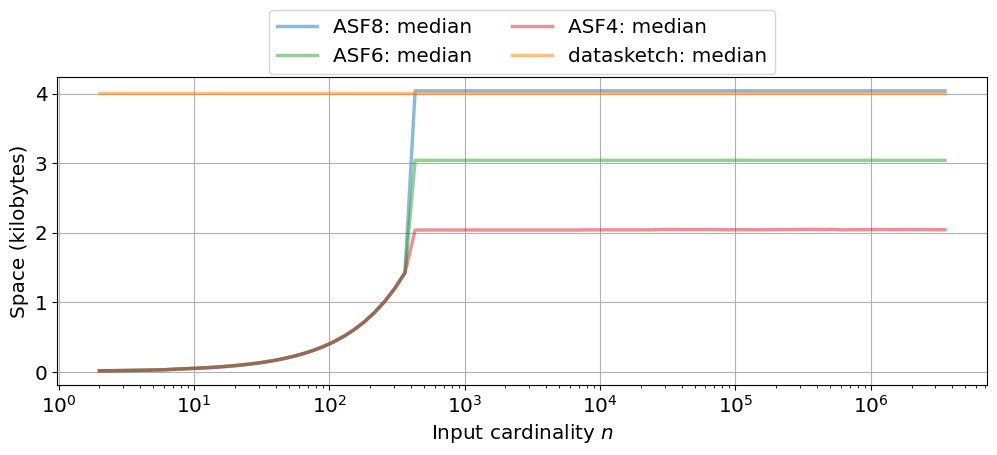

In [12]:
fig, ax = plt.subplots(figsize=(12,4))

methods = ["ASF8", "ASF6", "ASF4", "datasketch"]

for i, (method, colour, df) in enumerate(zip(methods, [asf8_color, asf6_color, asf4_color, ds_color], [asf8, asf6, asf4, dsk])):
    xn = df.index 
    median = df.median(axis=1)
    ax.plot(xn, median / 1024,
           color=colour, label=method+": median", alpha=0.5)

ax.set_xscale('log', base=10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol=2, fancybox=True)
ax.grid()
ax.set_ylabel("Space (kilobytes)")
ax.set_xlabel(r"Input cardinality $n$")
# ax.set_ylim(0.6E-6, 1.6E-6)

Each of the ASF methods go through some resizing and growth stages until a maximum size is reached.  At this point the sketches grow no further.  As expected, the $4$ bit version is half the size of the $8$ bit version and the $6$ bit version is $3/4$ the size of the $8$ bit version.  Once the $8$ bit ASF HLL enters its final stage, it is the same size as the datasketch HLL, but can be much smaller prior to this stage.